In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as snb
snb.set()
import matplotlib.font_manager as fm
myfont = fm.FontProperties(fname='idx/msyh.ttf')

In [3]:
idx_return_df = pd.read_csv("idx_return_df.csv")

In [4]:
idx_return_df = idx_return_df.drop("Unnamed: 0", axis=1).set_index('tradeDate')

In [5]:
idx_return_df.head()

,深证成指,沪深300,中证500,上证50,中小板指,创业板指,上证综指
tradeDate,,,,,,,
2014-01-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2014-01-03,0.989394,0.986563,0.991797,0.983965,1.001831,1.014881,0.987555
2014-01-06,0.963530,0.964108,0.964401,0.969144,0.978531,0.992742,0.969812
2014-01-07,0.962033,0.963833,0.970317,0.967686,0.985993,1.014458,0.970574
2014-01-08,0.961520,0.965516,0.971498,0.970683,0.992195,1.054028,0.969163


In [6]:
def polyfit(y, n, deg=2):
    x = np.linspace(0, 1, n)
    reg = np.polyfit(x, y, deg)
    if deg == 1:
        return reg[0]
    elif deg == 2:
        return reg[0] * 2 + reg[1]

In [7]:
def distance_to_plant(x):
    return (x[-1] - x[0]) / x[0]

In [8]:
def fit2(df, n1, n2, n3, n4):
    r0 = idx_return_df.rolling(30).mean()
    r1 = r0.rolling(n1, min_periods=n1).apply(myfit,args=(n1,))
    r2 = r1.rolling(n2).mean()
#     r3 = r2.rolling(n3, min_periods=n3).apply(myfit,args=(n3,))
#     r4 = r3.rolling(n4, min_periods=n4).mean()
    return r2

In [9]:
def distance(df, n_average, n_days_ago):
    ma = df.rolling(n_average).mean()
    ma = ma.dropna()
    n = n_days_ago
    d = ma.rolling(n, min_periods=n).apply(distance_to_plant)
    return d

In [10]:
def velocity(distance, n_point):
    n = n_point
    v = distance.rolling(n, min_periods=n).apply(polyfit, args=(n,))
    return v

In [32]:
begin_date = "2016-01-01"
end_date = "2018-01-01"
idx = "中证500"

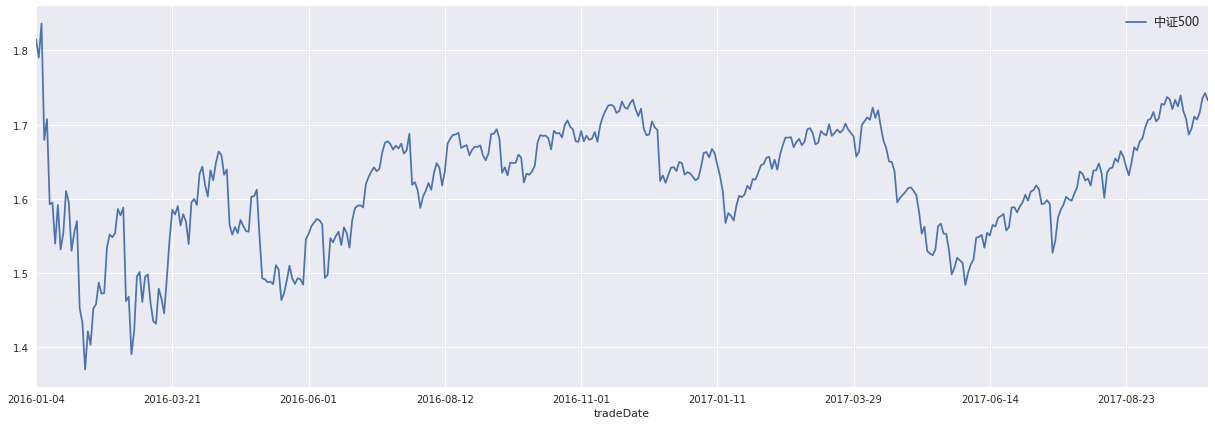

In [33]:
ax = idx_return_df.loc[begin_date:end_date, idx].plot(figsize=(21, 7))
legend = ax.legend()
for text in legend.texts:
    text.set_font_properties(myfont)

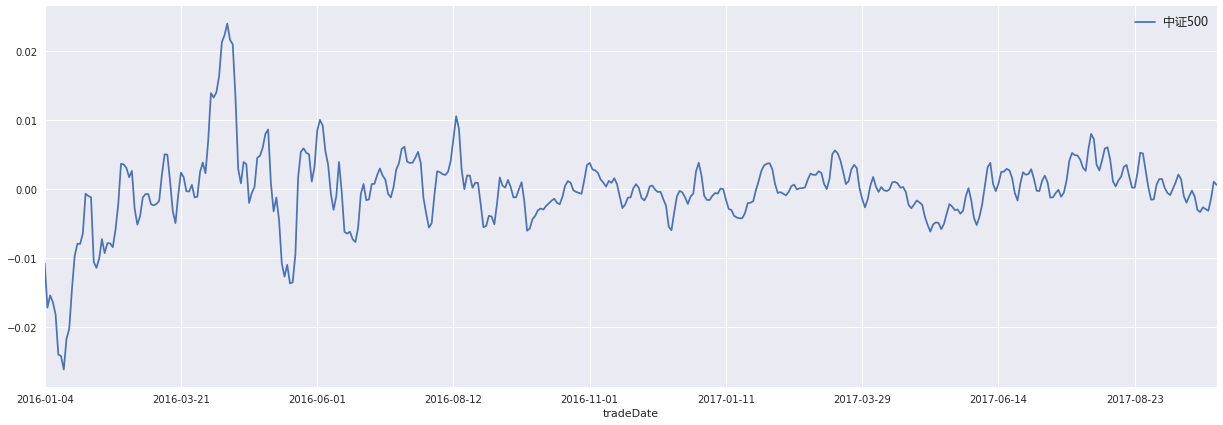

In [34]:
ax = v.loc[begin_date:end_date, idx].plot(figsize=(21, 7))
# a.loc[begin_date:end_date, idx].plot(figsize=(21, 7))
legend = ax.legend()
for text in legend.texts:
    text.set_font_properties(myfont)

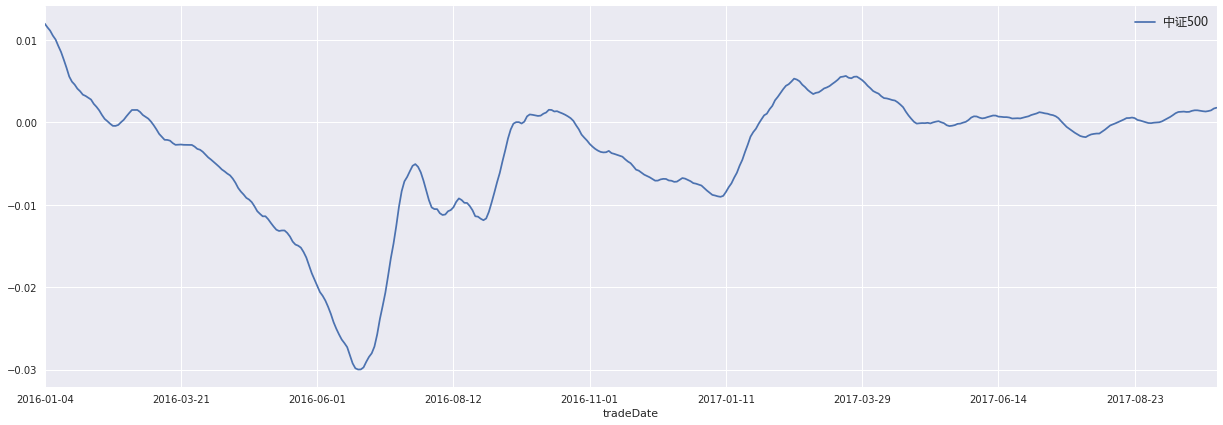

In [36]:
d = distance(idx_return_df, 250, 11)
ax = d.loc[begin_date:end_date, idx].plot(figsize=(21, 7))
# v.loc[begin_date:end_date, idx].rolling(3).mean().plot(figsize=(21, 7))
# a.loc[begin_date:end_date, idx].rolling(3).mean().plot(figsize=(21, 7))
legend = ax.legend()
for text in legend.texts:
    text.set_font_properties(myfont)

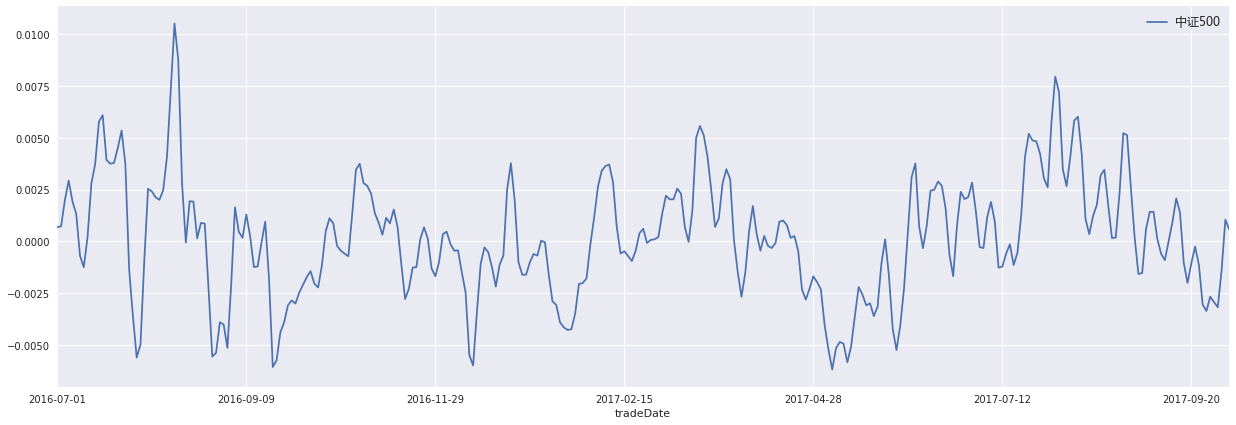

In [31]:
v = velocity(d, 5)
ax = v.loc[begin_date:end_date, idx].plot(figsize=(21, 7))
#a.loc[begin_date:end_date, idx].plot(figsize=(21, 7))
legend = ax.legend()
for text in legend.texts:
    text.set_font_properties(myfont)

In [ ]:
a = velocity(v, 10)
ax = a.loc[begin_date:end_date, idx].plot(figsize=(21, 7))
legend = ax.legend()
for text in legend.texts:
    text.set_font_properties(myfont)

In [ ]:
up_cond = (d[idx] > 0) #& (v[idx] > 0) # & (a[idx]>0)

In [ ]:
up = idx_return_df[up_cond.index.values[0]:][up_cond==True][idx]

In [ ]:
down_cond = (d[idx] < 0) #& (v[idx] < 0) # & (a[idx]<0)

In [ ]:
down = idx_return_df[down_cond.index.values[0]:][down_cond==True][idx]

In [ ]:
up.head()

In [ ]:
down.head()

In [ ]:
zh_return = idx_return_df[idx] - idx_return_df[idx].shift(1)
zh_return_signal = pd.concat([zh_return, up, down], axis=1)
zh_return_signal.columns = ['idx', 'long', 'short']
zh_return_signal['long'] = zh_return_signal['long'].shift(1)
zh_return_signal['short'] = zh_return_signal['short'].shift(1)
zh_return_signal.tail()
zh_return_signal = zh_return_signal.fillna(0)
def cal_profit(x):
    if x['long'] > 0:
        profit = x['idx']
    elif x['short'] > 0:
        profit = -x['idx']
    else:
        profit = 0
    return profit

zh_return_signal['profit'] = zh_return_signal.apply(cal_profit, axis=1)
begin_date = "2017-01-01"
end_date = "2018-01-01"
(zh_return_signal[zh_return_signal['long'] > 0]['profit'] + 1)[begin_date:end_date].cumprod().plot(figsize=(21, 7))

In [ ]:
def fixed_stop_loss(df, min_return, stop_loss, withdraw, withdraw_percent, column='close'):
    init = df.iloc[0][column]
    max_return = -1
    for idx, row in df.iterrows():
        return_ = row[column] - init
        #print(return_)
        
        if return_ >= max_return:
            # 盈利创新高，继续持仓
            max_return = return_
        else:
            # 盈利下降
            if return_ > min_return:
                # 盈利大于最小盈利
                if return_ * (1 + withdraw_percent) < max_return and (max_return - return_) > withdraw:
                    # 回撤大于固定回撤和回撤百分比
                    break
            else:
                if return_ < init * (- stop_loss):
                    # 止损
                    break
                
    return idx, return_

In [ ]:
def fixed_stop_loss(market, open_signal, min_return, stop_loss, withdraw, withdraw_percent):
    df = pd.concat([market, open_signal], axis=1)
    df.columns = ['price', 'signal']
    df['new_signal'] = 0
    open_status = False
    for idx, row in df.iterrows():
        if open_status:
            df.loc[idx,'new_signal'] = 1
            
            return_ = row['price'] - init
            #print(return_)

            if return_ >= max_return:
                # 盈利创新高，继续持仓
                max_return = return_
            else:
                # 盈利下降
                if return_ > min_return:
                    # 盈利大于最小盈利
                    if return_ * (1 + withdraw_percent) < max_return and (max_return - return_) > withdraw:
                        # 回撤大于固定回撤和回撤百分比, 止盈
                        open_status = False
                else:
                    if return_ < init * (- stop_loss):
                        # 止损
                        open_status = False
        else:
            if df.loc[idx, 'signal'] == 1:
                open_status = True
                init = df.loc[idx]['price']
                max_return = 0
                df.loc[idx, 'new_signal'] = 1
            else:
                df.loc[idx, 'new_signal'] = 0

    
    return df['new_signal']

In [ ]:
idx_return_df.head()

In [ ]:
up.head()

In [ ]:
idx_return_df.head()

In [ ]:
idx

In [ ]:
idx_return_close = idx_return_df[idx]

In [ ]:
idx_return_close.head()

In [ ]:
idx_return_close.name = 'close'

In [ ]:
up.name = 'signal_weight'

In [ ]:
market_signal = pd.concat([idx_return_close, up], axis=1)

In [ ]:
market_signal['signal_weight'] = market_signal['signal_weight'].shift(1)

In [ ]:
market_signal.loc[market_signal['signal_weight'] > 0, 'signal_weight'] = 1 

In [ ]:
market_signal = market_signal.fillna(0)

In [ ]:
signal = market_signal['signal_weight']

In [ ]:
def singal_refine(signal, window, refine_func, func_paras):
    new_signal = signal.rolling(window).apply(refine_func, args = func_paras)
    return new_signal

In [ ]:
signal.tail()

In [ ]:
def signal_refine_func1(x, threshold):
    signal = 0
    sum_weigth = x.sum()
    if sum_weigth > threshold:
        signal = 1
    else:
        signal = 0
    return signal

In [ ]:
open_signal = singal_refine(signal, 2, signal_refine_func1, (1,))

In [ ]:
open_signal = open_signal.fillna(0)

In [ ]:
open_signal.head()

In [ ]:
#fixed_stop_loss(market, open_signal, min_return, stop_loss, withdraw, withdraw_percent):
signal = fixed_stop_loss(idx_return_close, open_signal, 0.003, 0.003, 0.005, 0.1)

In [ ]:
zh_return = idx_return_df[idx] - idx_return_df[idx].shift(1)
zh_return_signal = pd.concat([zh_return, signal], axis=1)
zh_return_signal.columns = ['profit', 'long']
# zh_return_signal['long'] = zh_return_signal['long'].shift(1)
# zh_return_signal['short'] = zh_return_signal['short'].shift(1)
# zh_return_signal.tail()
# zh_return_signal = zh_return_signal.fillna(0)
# def cal_profit(x):
#     if x['long'] > 0:
#         profit = x['idx']
#     elif x['short'] > 0:
#         profit = -x['idx']
#     else:
#         profit = 0
#     return profit

# zh_return_signal['profit'] = zh_return_signal.apply(cal_profit, axis=1)
begin_date = "2016-01-01"
end_date = "2017-01-01"
(zh_return_signal[zh_return_signal['long'] > 0]['profit'] + 1)[begin_date:end_date].cumprod().plot(figsize=(21, 7))
(zh_return_signal[zh_return_signal['long'] > 0]['profit'] + 1)[begin_date:end_date].cumprod().plot(figsize=(21, 7))

In [ ]:
df.plot(kind='scatter', x='col1', y='col2', s=df.col3)